# 프로젝트: 네이버 영화리뷰 감성분석 도전하기

##  데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어온다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

IMDB 데이터셋은 텍스트를 가공하여 `imdb.data_loader()` 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 제공된다.   
그러나 이번에 다루게 될 `nsmc` 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있으며, 이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 본다. `data_loader` 안에서는 다음을 수행하게 된다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴


In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작한다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가



In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험

### 1) RNN 모델

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 2) CNN 모델 - Conv1D

In [27]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [28]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 3) CNN 모델 - GlobalMaxPooling

In [36]:
vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [37]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 훈련 개시

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 11ms/step - loss: 0.6000 - accuracy: 0.6987 - val_loss: 0.3596 - val_accuracy: 0.8476
Epoch 2/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3432 - accuracy: 0.8573 - val_loss: 0.3405 - val_accuracy: 0.8520
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3134 - accuracy: 0.8697 - val_loss: 0.3390 - val_accuracy: 0.8526
Epoch 4/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3011 - accuracy: 0.8755 - val_loss: 0.3382 - val_accuracy: 0.8530
Epoch 5/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2913 - accuracy: 0.8804 - val_loss: 0.3381 - val_accuracy: 0.8546
Epoch 6/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2837 - accuracy: 0.8833 - val_loss: 0.3387 - val_accuracy: 0.8538
Epoch 7/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2751 - accuracy: 0.8873 - val_loss: 0.3401 - val_accuracy: 0.8538

In [12]:
history_dict = history.history

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4706 - accuracy: 0.8431
[0.47060033679008484, 0.8430742025375366]


## Loss, Accuracy 그래프 시각화

## RNN 모델로 학습시켰을 때

1537/1537 - 5s - loss: 0.5025 - accuracy: 0.8382   
[0.47060033679008484, 0.8430742025375366]

#### Loss
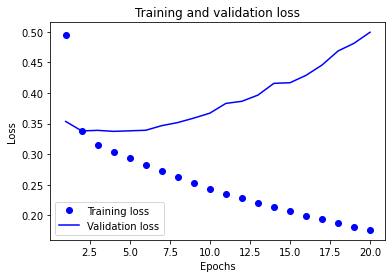

#### Accuracy
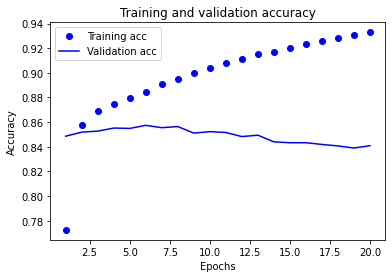

RNN모델로 학습시켰을 때,    
Validation loss는 epoch횟수가 증가할수록 높아지며 Training loss는 떨어지는 경향이 보인다.
Validation acc는 epoch횟수가 증가해도 소폭으로 Accuracy가 떨어지며, Training acc는 증가하는 경향을 보인다.

## CNN모델 - Conv1D 로 학습시켰을 때


1537/1537 - 3s - loss: 1.0240 - accuracy: 0.8182   
[1.0240081548690796, 0.8181540966033936]

#### Loss
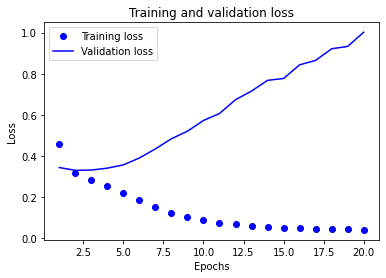

#### Accuracy
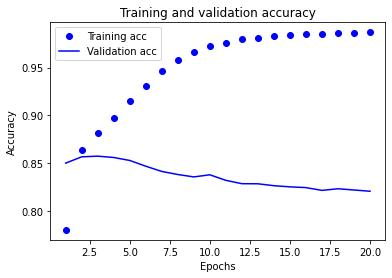

RNN모델을 사용했을 때 보다 Training 부분의 Loss가 더 빨리 감소하는 것을 볼 수 있으며,    
Accuracy 에서의 training acc가 RNN모델보다 점수가 높고 overfitting현상이 일어나는 것을 볼 수 있다.

## CNN모델 - GlobalMaxPooling로 학습시켰을 때

1537/1537 - 2s - loss: 0.5182 - accuracy: 0.8269   
[0.5181829333305359, 0.8269015550613403]

#### Loss
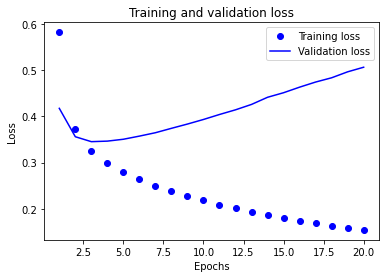

#### Accuracy
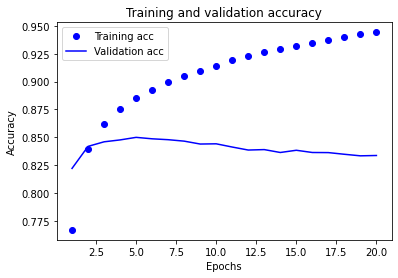

Loss에서 validation loss가 한번 감소했다가 다시 증가하는 것을 볼 수 있다. 앞에 두 RNN과 CNN과는 다른 현상이다.   
Accuracy에서 validation acc가 증가했다가 소~~~~~~폭으로 감소하며 기어가는 것을 볼 수 있다. 이 역시 앞 두모델과는 다른점이다.

## 학습된 Embedding 레이어 분석

In [14]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [15]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장한다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-6, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록한다.
vectors = model.get_weights()[0]
for i in range(6, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [16]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word2vec['사람']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([-0.3190452 ,  0.17484948, -0.17107269,  0.0210535 , -0.19189723,
        0.06972351,  0.136914  , -0.12419365, -0.1379368 ,  0.1216744 ,
       -0.21994627, -0.01295348,  0.05557725,  0.15874045, -0.1371444 ,
        0.11383771], dtype=float32)

In [17]:
word2vec.similar_by_word("사람")

[('점주', 0.9450762867927551),
 ('주관', 0.9360395669937134),
 ('차이', 0.9333500266075134),
 ('여', 0.9319793581962585),
 ('소설', 0.9274057745933533),
 ('http', 0.923757016658783),
 ('빙자', 0.920720100402832),
 ('정신', 0.9130425453186035),
 ('띄우', 0.9073964953422546),
 ('지라', 0.9034084677696228)]

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(6, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [19]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 20ms/step - loss: 0.5251 - accuracy: 0.7339 - val_loss: 0.3564 - val_accuracy: 0.8462
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2969 - accuracy: 0.8783 - val_loss: 0.3487 - val_accuracy: 0.8493
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2748 - accuracy: 0.8892 - val_loss: 0.3488 - val_accuracy: 0.8503
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2567 - accuracy: 0.8977 - val_loss: 0.3483 - val_accuracy: 0.8522
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2366 - accuracy: 0.9075 - val_loss: 0.3526 - val_accuracy: 0.8525
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2160 - accuracy: 0.9174 - val_loss: 0.3692 - val_accuracy: 0.8514
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.1973 - accuracy: 0.9266 - val_loss: 0.3823 - val_accuracy: 0.8481
Epoch

In [21]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.8416 - accuracy: 0.8299
[0.8415787816047668, 0.8298512697219849]


---
## 정리 
train data가 크기가 작기 때문에 loss값이 작게 나왔지만, 실제 test데이터를 model에 넣고 평가해보면 loss값이 train때보다 크다.   
다양한 모델을 이용해서 임베딩을 할수 있지만, 가장 적합한 것은 역시 RNN인 것 같다.
RNN모델을 사용 시 loss와 accuracy 둘다 안정적이다.